In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn import metrics
from sklearn.metrics import r2_score


from itertools import combinations

In [2]:


Company = pd.read_csv("Apple.csv",index_col=0)
Google_trends_df = pd.read_csv("./New Data/Google_trends_data_updated.csv",index_col=0)
All = pd.read_csv("All.csv",index_col=0)

# Datetime for Apple
Company.date = pd.to_datetime(Company.date)
Company['Date_date']=Company['date'].apply(lambda x:x.date())
Company.Date_date = pd.to_datetime(Company.Date_date)
Company = Company.set_index('date')
All.index = pd.to_datetime(All.index)
# Adding Zika trends data
Company = pd.concat([Company, Google_trends_df['Covid-19'], Google_trends_df['zika']],axis=1)


Company = Company[2:-3] # from 2011-01-03 to 2020-04-27



Company['time'] = Company.index.to_series().apply(lambda x: x.toordinal())

Company = Company[['company_news','world_news','company_trends','Coronavirus', 'presidential election', 'Lockdown','Pandemic', 'Quarantine'

,'zika','Covid-19','time','Close']]

In [3]:
# slicing for time windows
Covid_19 = Company['2020-01-01':'2020-04-30']
Zika = Company['2015-01-01':'2016-01-01']
election_2016 = Company['2016-06-01':'2017-05-30']
election_2012 = Company['2012-06-01':'2013-05-30']

In [4]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def predict(theta, X):
    return np.dot(X, theta)

def getThetaClosedForm(X,Y):
    theta = np.linalg.inv(X.T@X)@X.T@Y
    return theta

# Covid

In [5]:
df = Covid_19

In [6]:
df.index = pd.to_datetime(df.index)


In [7]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [8]:
cutIdx = int(len(std_df)*0.7)

In [9]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 'Coronavirus',
                                                           'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
                                                           'Covid-19', 'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Covid_19 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Covid_19 timewindow: 
                       Coefficient
Quarantine                0.485810
Coronavirus              -0.461433
Covid-19                 -0.332620
Lockdown                 -0.315128
time                     -0.189859
company_trends           -0.176773
Bias_Constant             0.138979
zika                     -0.138024
presidential election     0.114272
company_news              0.049303
world_news                0.030267
Pandemic                  0.029600


In [10]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [11]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [12]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [13]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [14]:
Names = ['The Lowest root_mean_squared_error of the training set', 'The Lowest neg_mean_squared_error of the training set', 'The Lowest mean_absolute_percentage_error of the training set', 'The Highest R2_score of the training set']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

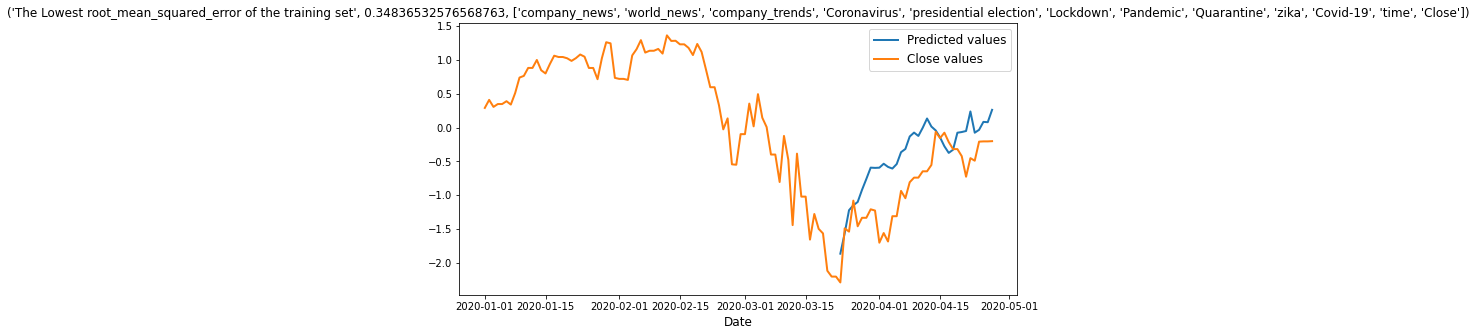

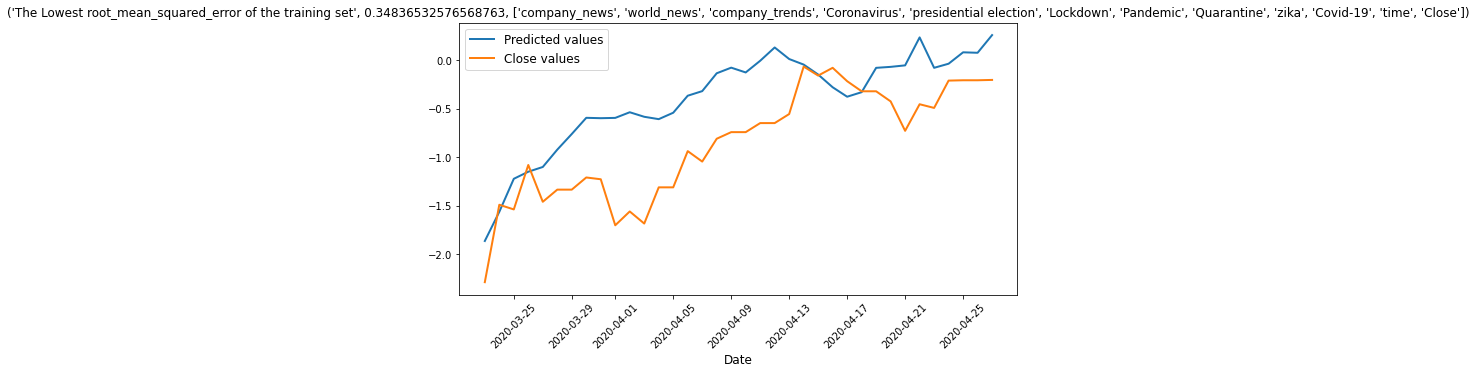

Root_mean_squared_error of the testing set:  0.5658493603892283
neg_mean_squared_error of the testing set:  -0.30032196426685304
mean_absolute_percentage_error of the testing set:  75.87713689656532
R2 score of the testing set:  -9.970399125402984e-05


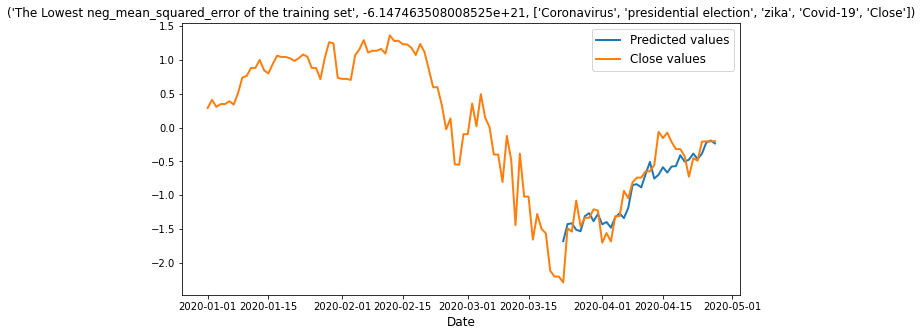

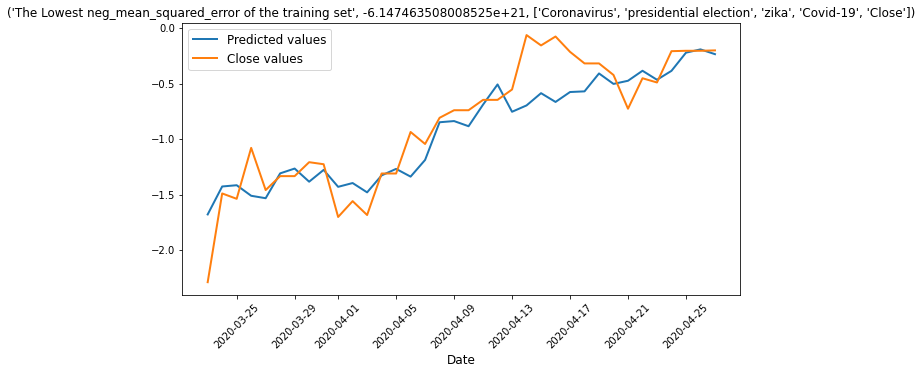

Root_mean_squared_error of the testing set:  0.25199913654793227
neg_mean_squared_error of the testing set:  -0.3770760816332873
mean_absolute_percentage_error of the testing set:  78.24475685058329
R2 score of the testing set:  0.801646555990271


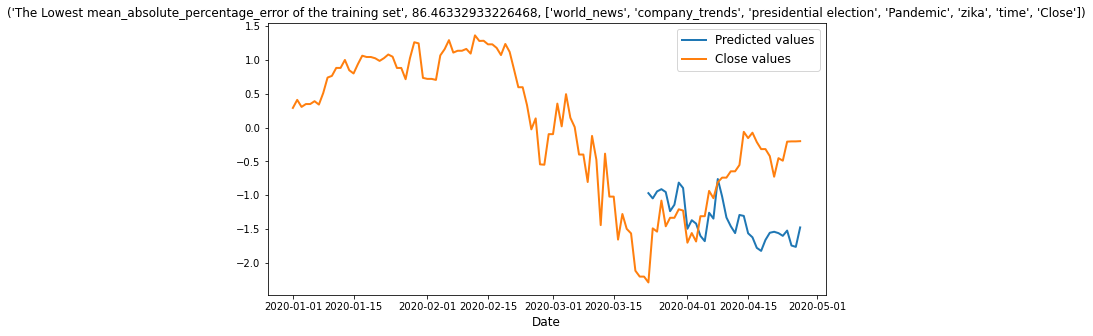

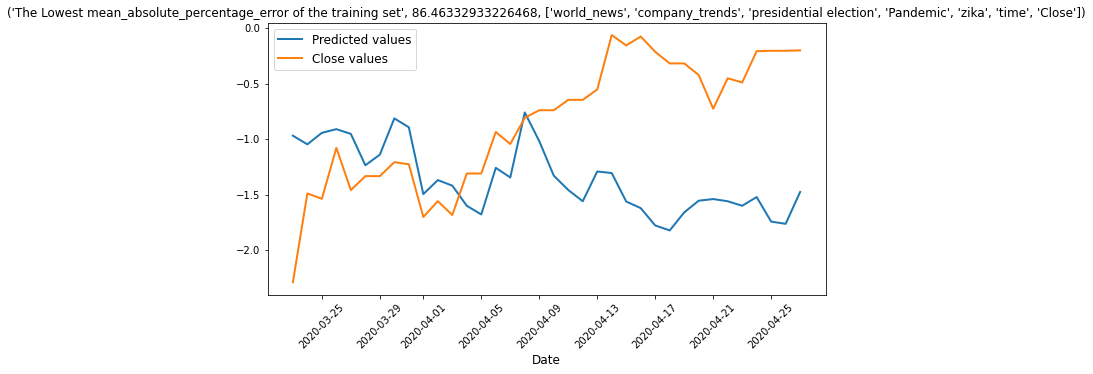

Root_mean_squared_error of the testing set:  0.9264535909114802
neg_mean_squared_error of the testing set:  -2.302934930238145
mean_absolute_percentage_error of the testing set:  306.9696714155613
R2 score of the testing set:  -1.6809516273559622


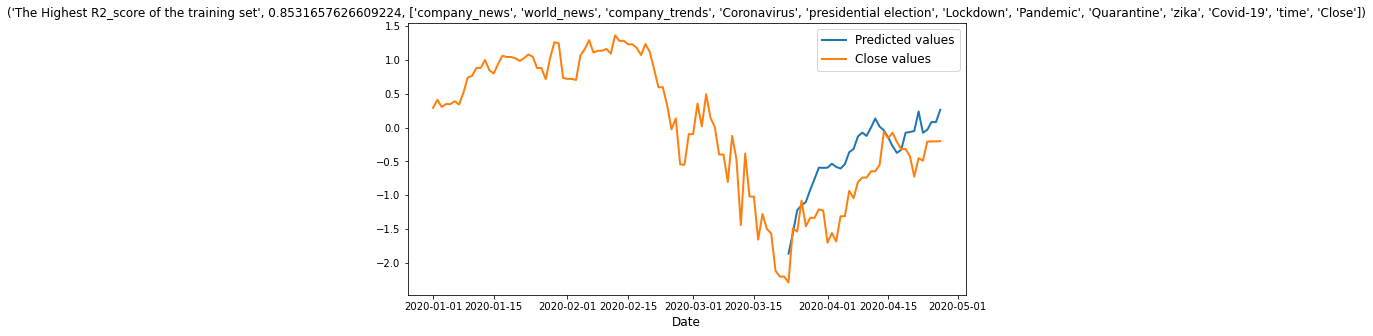

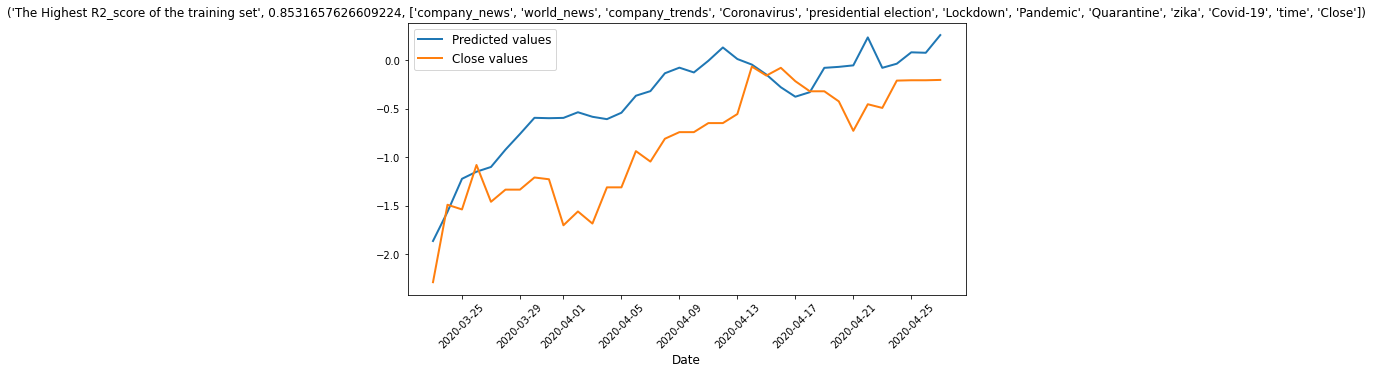

Root_mean_squared_error of the testing set:  0.5658493603892283
neg_mean_squared_error of the testing set:  -0.30032196426685304
mean_absolute_percentage_error of the testing set:  75.87713689656532
R2 score of the testing set:  -9.970399125402984e-05


In [15]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

In [16]:
print("The best performance features:", selected_High_performence_features[1][0])
print("Root_mean_squared_error:  0.25199913654793227")
print('neg_mean_squared_error:  -0.3770760816332873')
print('mean_absolute_percentage_error:  78.24475685058329')
print('R2 score:  0.801646555990271')

The best performance features: ['Coronavirus', 'presidential election', 'zika', 'Covid-19', 'Close']
Root_mean_squared_error:  0.25199913654793227
neg_mean_squared_error:  -0.3770760816332873
mean_absolute_percentage_error:  78.24475685058329
R2 score:  0.801646555990271


In [17]:
features_from_other_timewindows_based_on_Coefficients = [[['zika','Lockdown','company_trends','company_news','Close'],"Zika"],
                                                         [['time','presidential election','Lockdown','company_news','Close'],'Election 2012'],
                                                         [['time','zika','company_trends','company_news','Close'], 'Election 2016']]



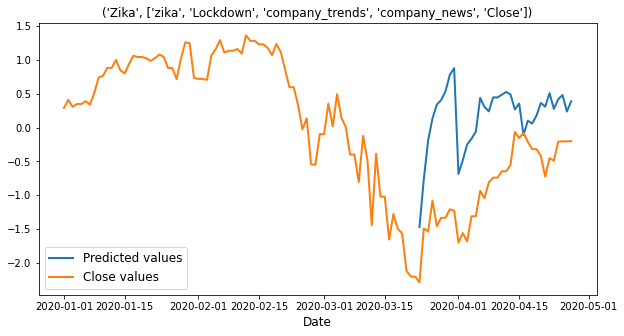

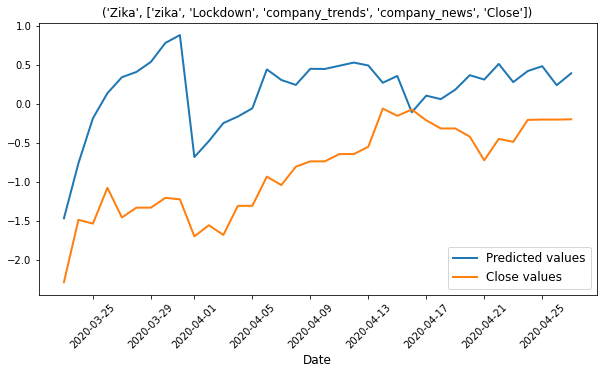

Root_mean_squared_error:  1.1374595476509883
neg_mean_squared_error:  -0.8580656448413023
mean_absolute_percentage_error:  161.99866380397515
R2 score:  -3.041229932112061


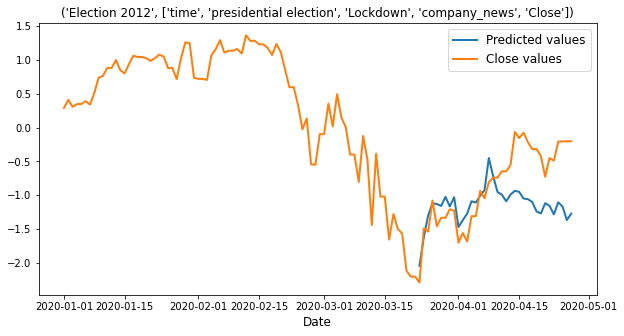

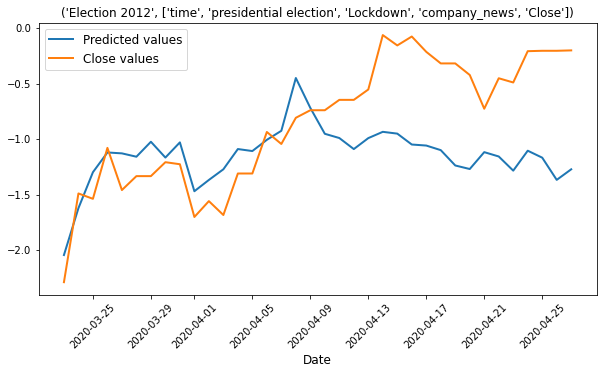

Root_mean_squared_error:  0.5820619877520026
neg_mean_squared_error:  -0.21697400498001831
mean_absolute_percentage_error:  198.32180612580632
R2 score:  -0.05823011454450144


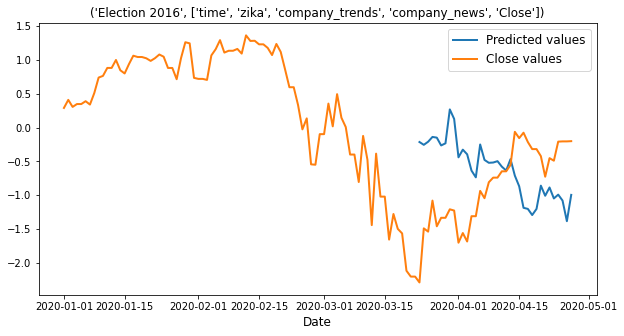

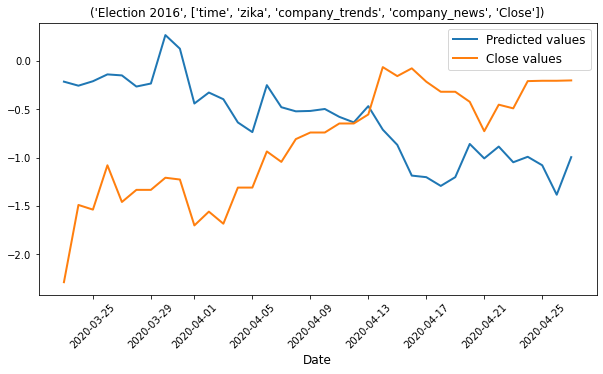

Root_mean_squared_error:  0.9450065363824255
neg_mean_squared_error:  -0.7306237738206475
mean_absolute_percentage_error:  208.29381325853387
R2 score:  -1.7894030084174033


In [18]:
for k,i in enumerate(features_from_other_timewindows_based_on_Coefficients):

    df_1 = std_df[i[0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.xticks(rotation=45)
    plt.show()
    
        # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score: ", R2_score)

# Zika

In [19]:
# removing covid_19, coronavirus features which have only 0s.
df = Zika[['company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        'time', 'Close']]

In [20]:
df.index = pd.to_datetime(df.index)


In [21]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [22]:
cutIdx = int(len(std_df)*0.7)

In [23]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Zika timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Zika timewindow: 
                       Coefficient
zika                     -0.811252
Lockdown                 -0.299300
company_trends           -0.172078
company_news              0.104049
Bias_Constant             0.100749
presidential election     0.076108
Quarantine               -0.046946
Pandemic                  0.042356
time                     -0.028449
world_news               -0.009646


In [24]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [25]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [26]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [27]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [28]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

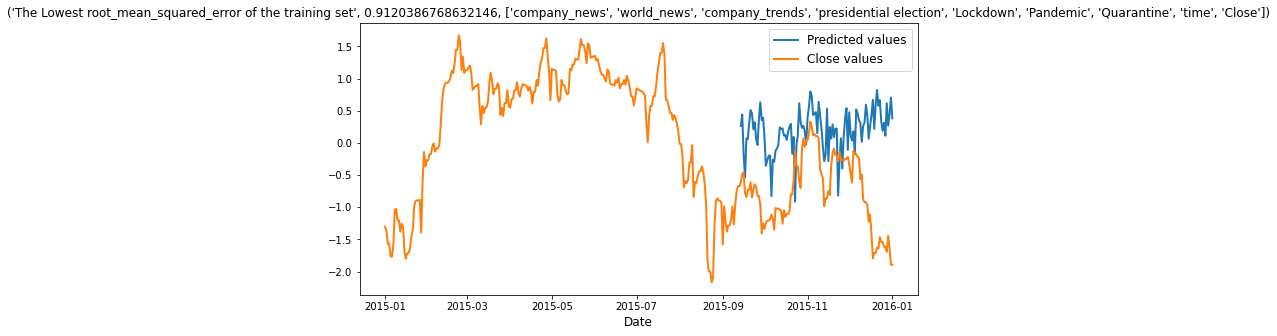

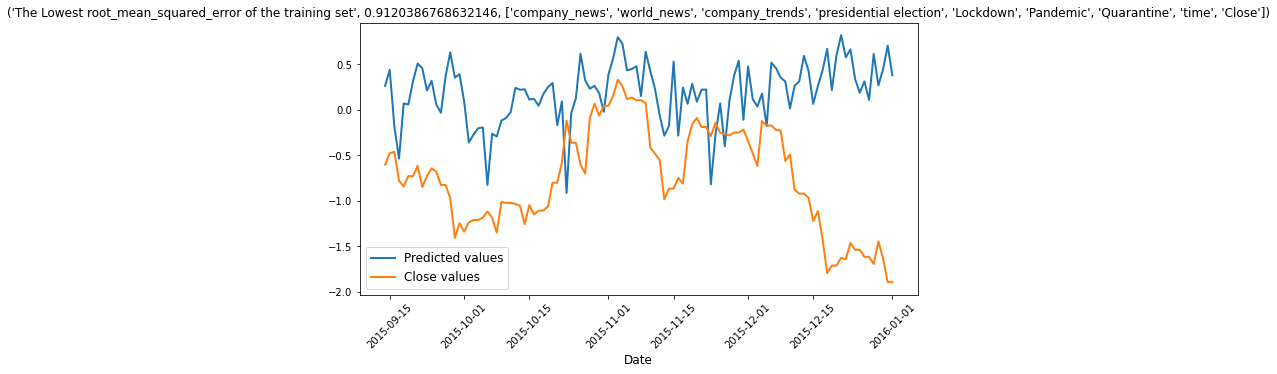

Root_mean_squared_error of the testing set:  1.1480112888839957
neg_mean_squared_error of the testing set:  -0.5524138370516003
mean_absolute_percentage_error of the testing set:  161.29779754461205
R2 score of the testing set:  -3.2929994676886896


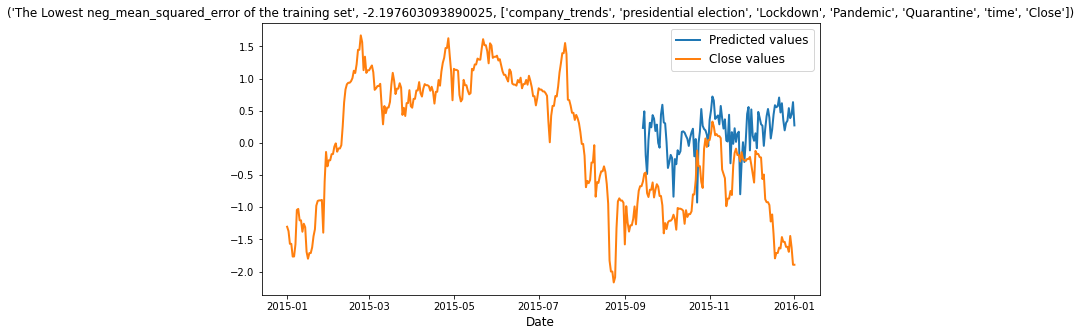

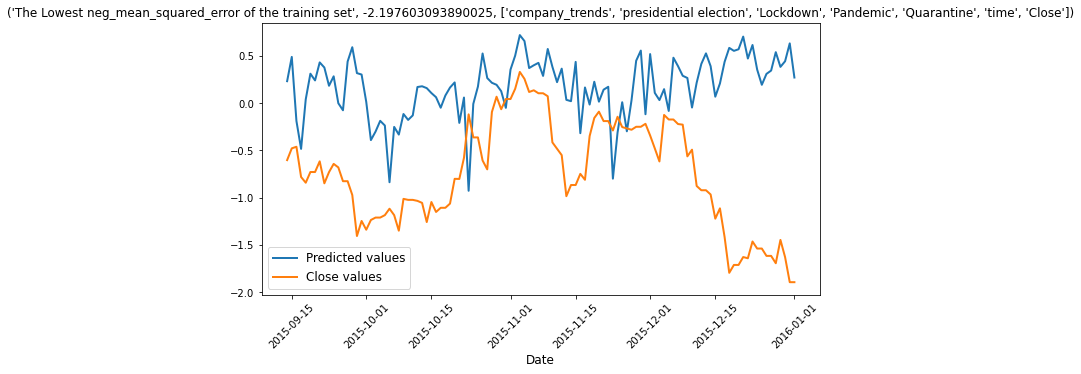

Root_mean_squared_error of the testing set:  1.1337489187500958
neg_mean_squared_error of the testing set:  -0.5264849211663676
mean_absolute_percentage_error of the testing set:  154.65365467184654
R2 score of the testing set:  -3.186993522605375


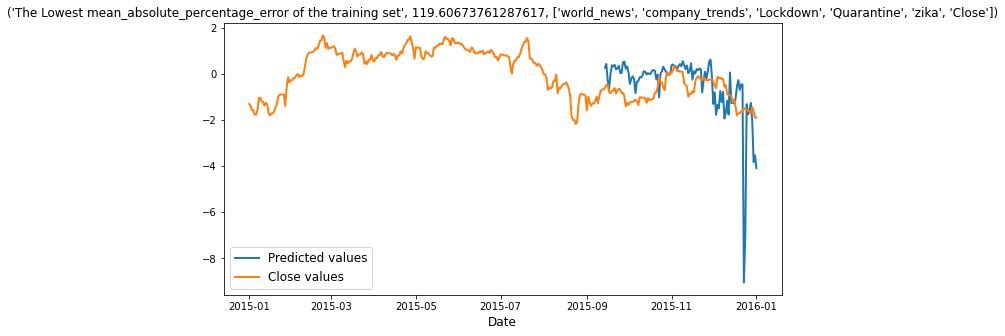

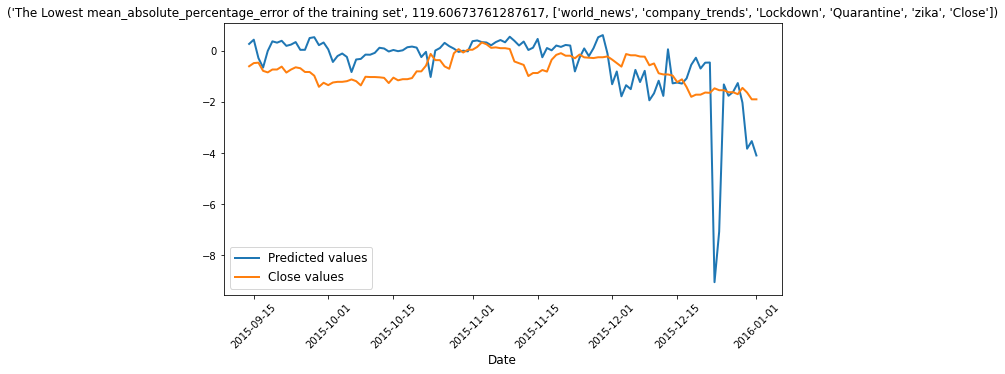

Root_mean_squared_error of the testing set:  1.26306956302928
neg_mean_squared_error of the testing set:  -0.3306938379093076
mean_absolute_percentage_error of the testing set:  159.1775128876534
R2 score of the testing set:  -4.196645085152422


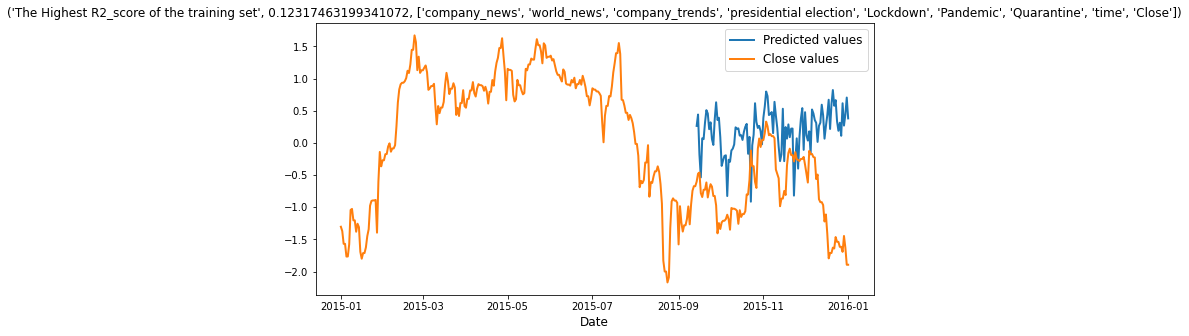

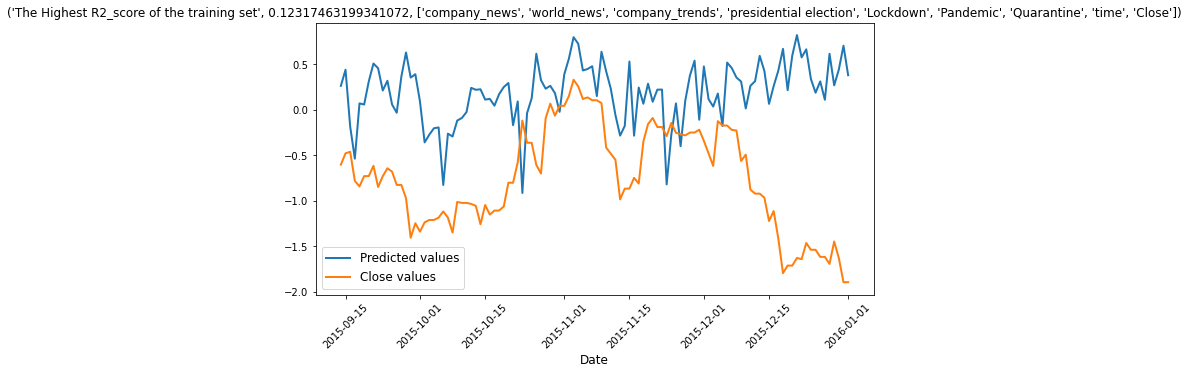

Root_mean_squared_error of the testing set:  1.1480112888839957
neg_mean_squared_error of the testing set:  -0.5524138370516003
mean_absolute_percentage_error of the testing set:  161.29779754461205
R2 score of the testing set:  -3.2929994676886896


In [29]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2012

In [30]:
# removing covid_19, coronavirus, zika features which have only 0s.
df = election_2012[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
        'time', 'Close']]

In [31]:
df.index = pd.to_datetime(df.index)


In [32]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [33]:
cutIdx = int(len(std_df)*0.7)

In [34]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Election 2012 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Election 2012 timewindow: 
                       Coefficient
time                     -0.548451
Bias_Constant             0.193188
presidential election     0.170093
Lockdown                 -0.106394
company_news              0.077032
world_news               -0.073001
Pandemic                 -0.055768
Quarantine                0.038013
company_trends           -0.027591


In [35]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [36]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [37]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [38]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [39]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

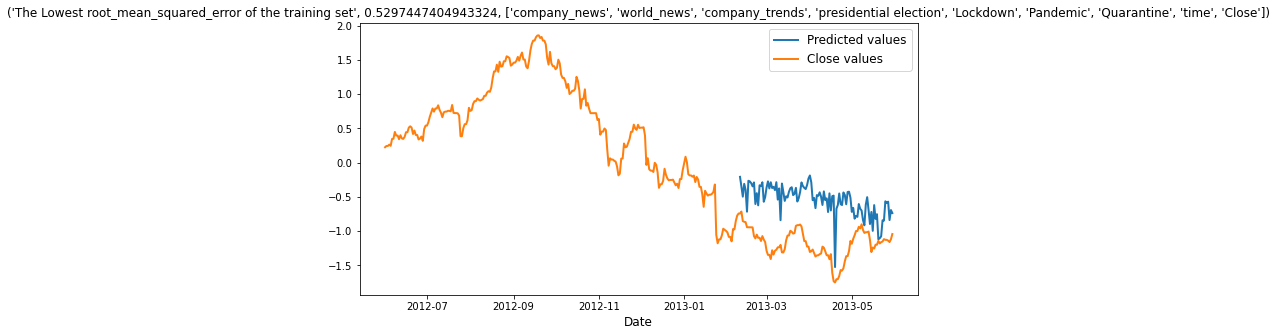

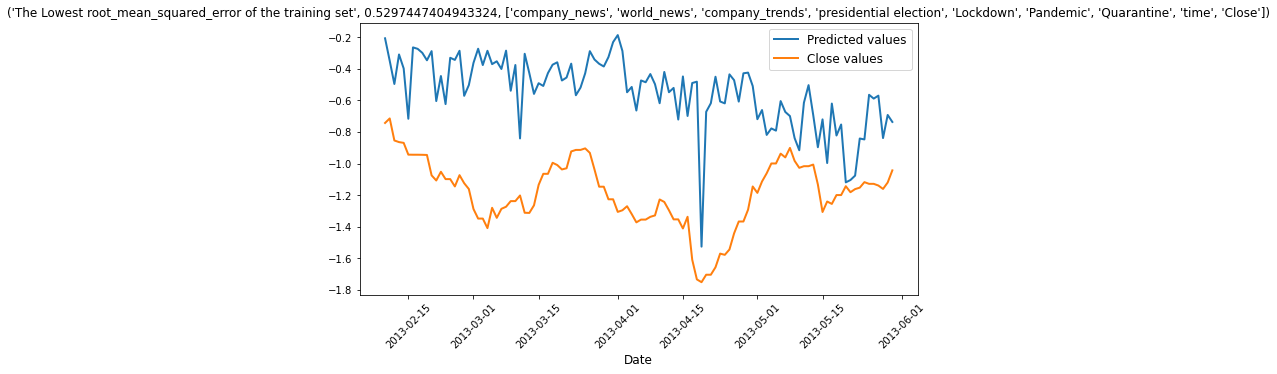

Root_mean_squared_error of the testing set:  0.6994404025848662
neg_mean_squared_error of the testing set:  -0.08820922410356931
mean_absolute_percentage_error of the testing set:  53.08772992210837
R2 score of the testing set:  -10.204227697726752


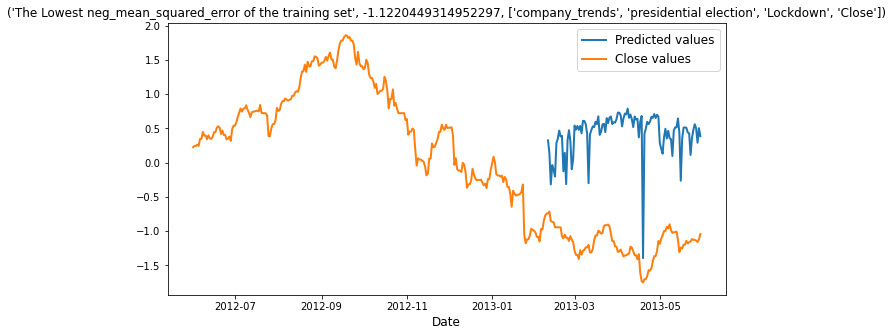

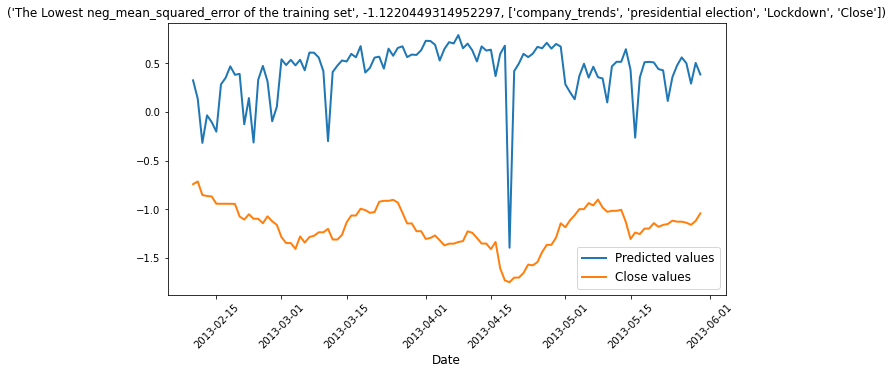

Root_mean_squared_error of the testing set:  1.656768871701874
neg_mean_squared_error of the testing set:  -0.0671454894755793
mean_absolute_percentage_error of the testing set:  136.1509167458258
R2 score of the testing set:  -61.86433819430275


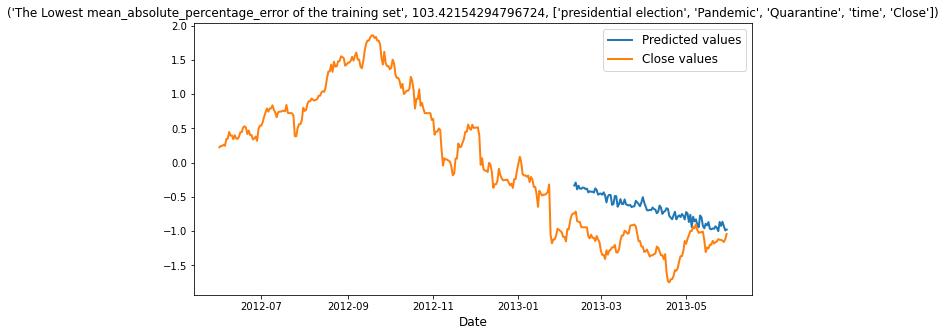

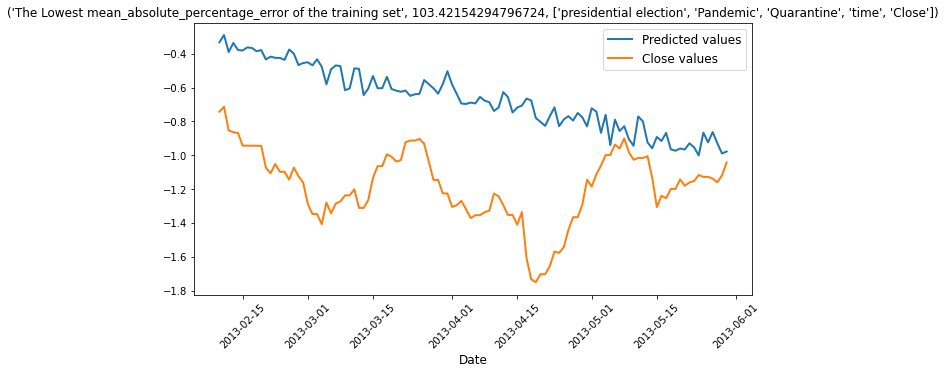

Root_mean_squared_error of the testing set:  0.5715824917164175
neg_mean_squared_error of the testing set:  -0.07985413889458928
mean_absolute_percentage_error of the testing set:  42.69670831146719
R2 score of the testing set:  -6.4823553571391095


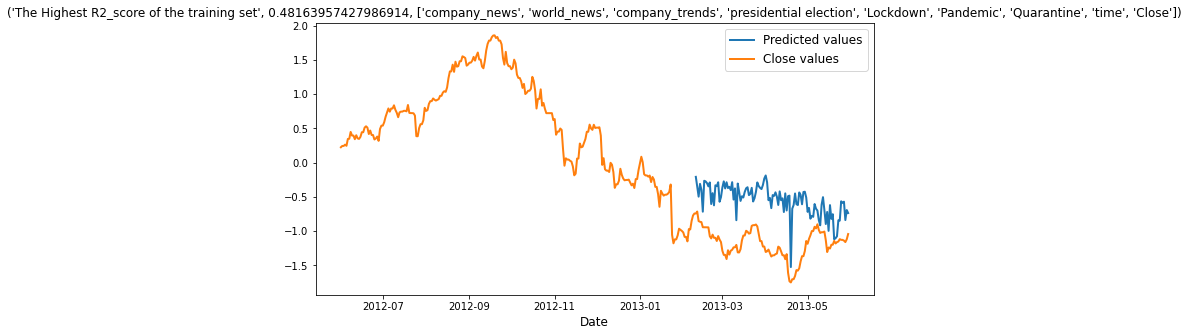

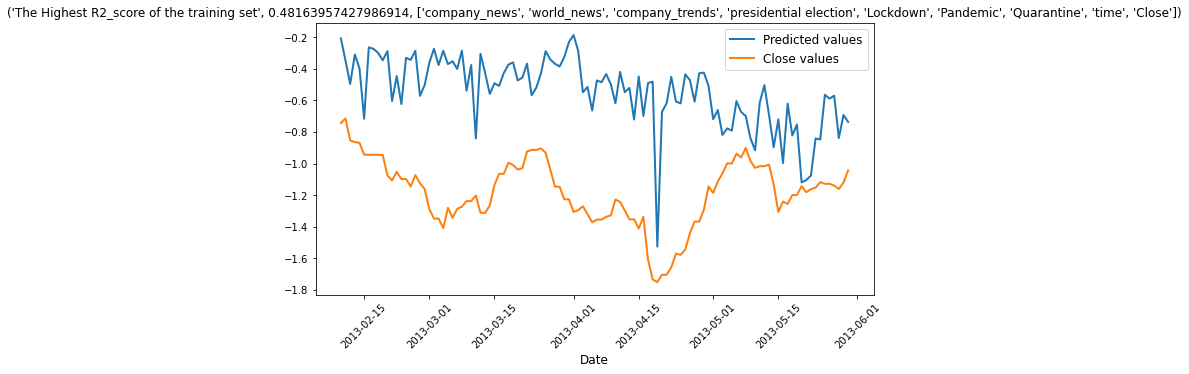

Root_mean_squared_error of the testing set:  0.6994404025848662
neg_mean_squared_error of the testing set:  -0.08820922410356931
mean_absolute_percentage_error of the testing set:  53.08772992210837
R2 score of the testing set:  -10.204227697726752


In [40]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2016

In [41]:
# removing covid_19, coronavirus features which have only 0s.
df = election_2016[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'time', 'Close']]

In [42]:
df.index = pd.to_datetime(df.index)


In [43]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [44]:
cutIdx = int(len(std_df)*0.7)

In [45]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Election 2016 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Election 2016 timewindow: 
                       Coefficient
time                      0.706301
Bias_Constant            -0.234752
zika                      0.084591
company_trends            0.046494
company_news              0.038045
Quarantine               -0.020736
Pandemic                  0.017442
presidential election     0.014590
Lockdown                 -0.012280
world_news                0.000978


In [46]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [47]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [48]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [49]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [50]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

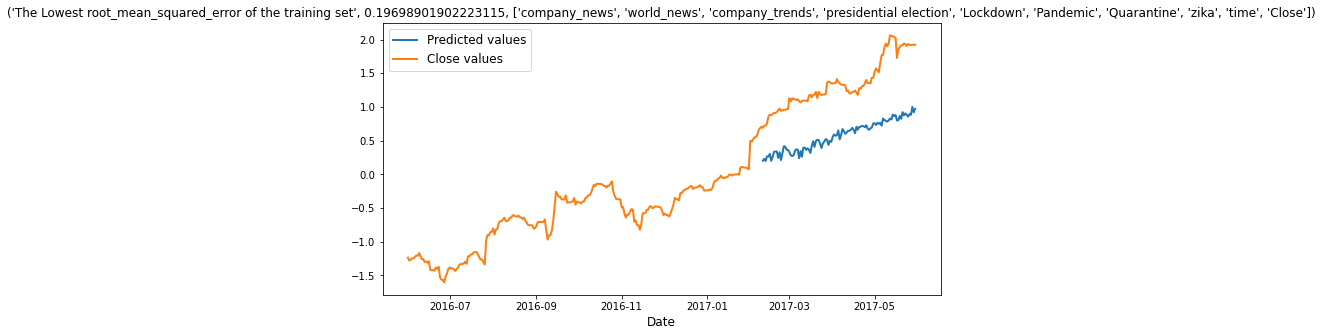

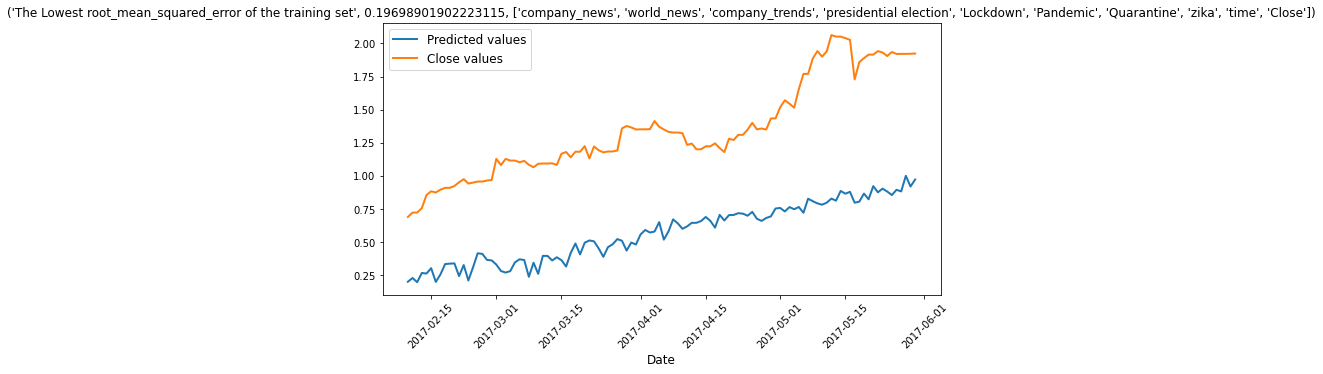

Root_mean_squared_error of the testing set:  0.7992621826464339
neg_mean_squared_error of the testing set:  -0.04205524267157461
mean_absolute_percentage_error of the testing set:  58.7182449276225
R2 score of the testing set:  -3.905748617957493


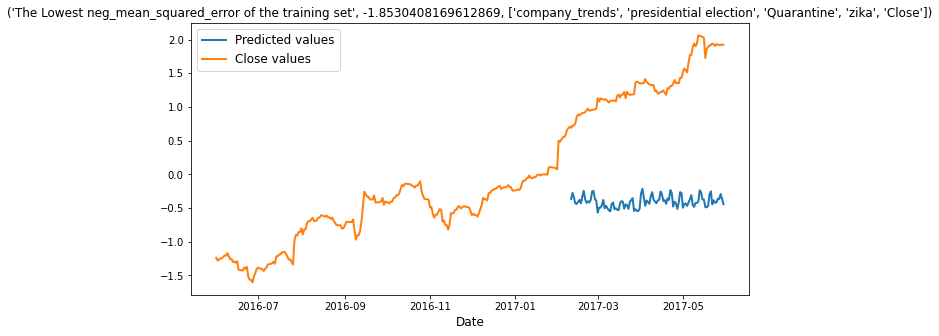

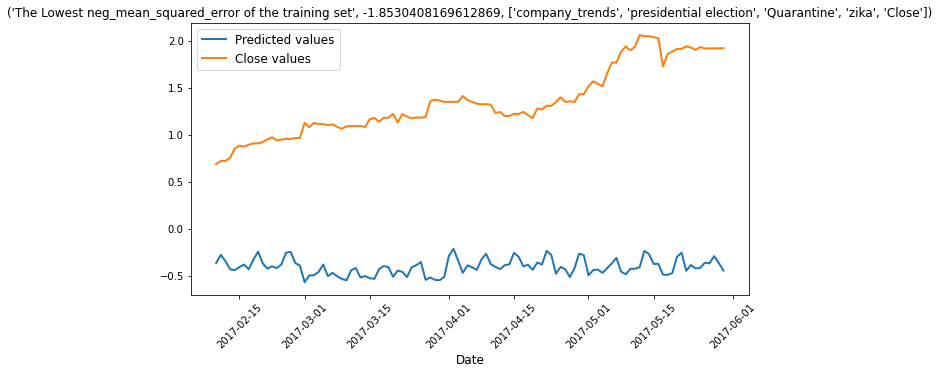

Root_mean_squared_error of the testing set:  1.7899100621785369
neg_mean_squared_error of the testing set:  -0.11256974440908189
mean_absolute_percentage_error of the testing set:  132.2644096232845
R2 score of the testing set:  -23.603063062526108


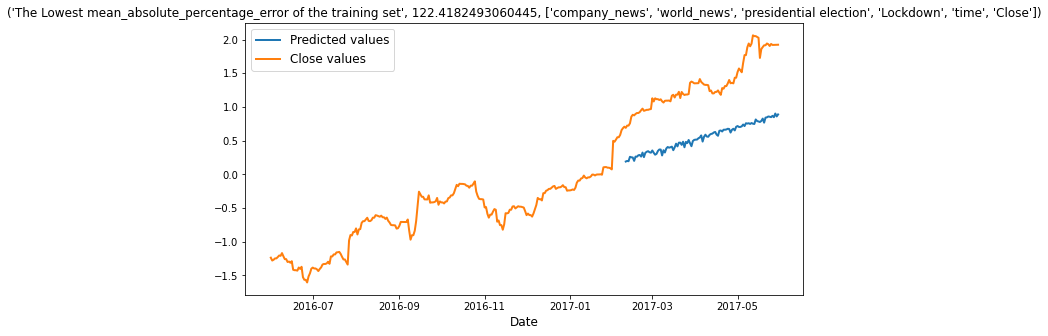

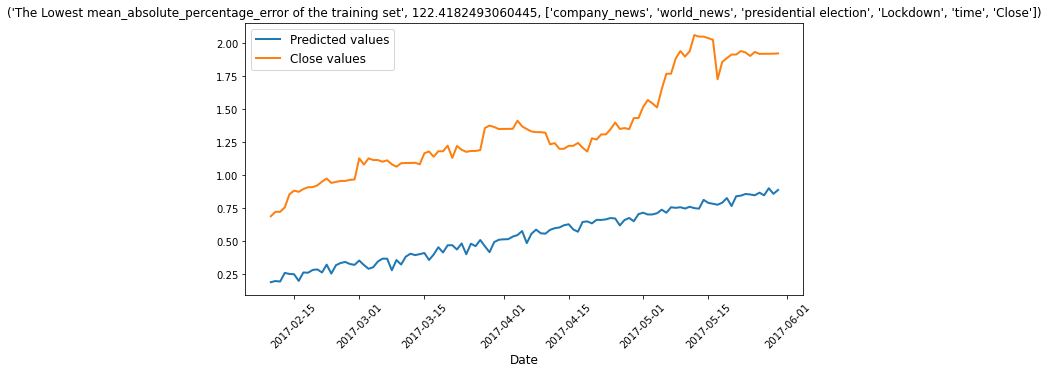

Root_mean_squared_error of the testing set:  0.8283810212696697
neg_mean_squared_error of the testing set:  -0.03187125348044043
mean_absolute_percentage_error of the testing set:  60.69859604496389
R2 score of the testing set:  -4.269713950693732


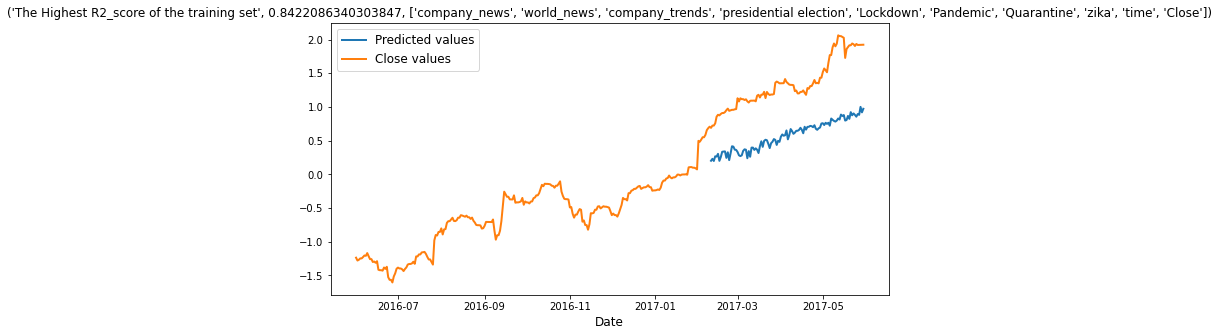

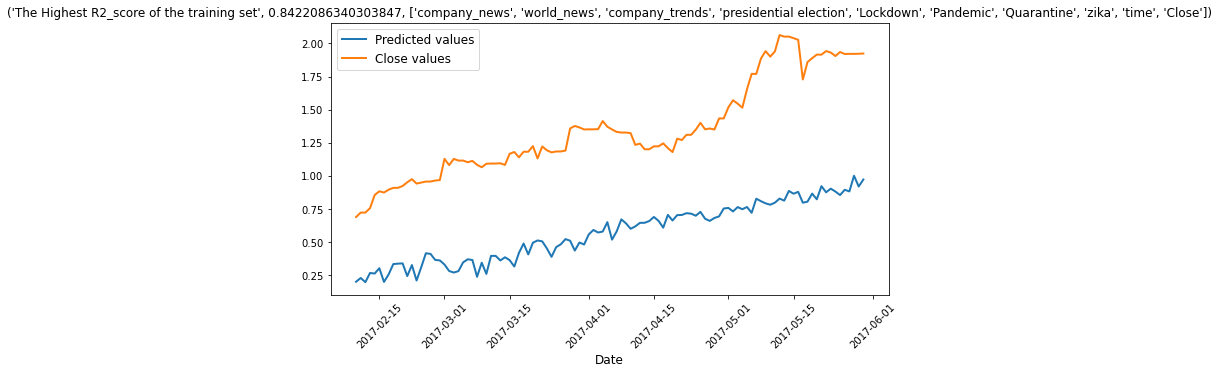

Root_mean_squared_error of the testing set:  0.7992621826464339
neg_mean_squared_error of the testing set:  -0.04205524267157461
mean_absolute_percentage_error of the testing set:  58.7182449276225
R2 score of the testing set:  -3.905748617957493


In [51]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# 10 years

In [52]:
# removing covid_19, coronavirus features which have only 0s.
df = Company


In [53]:
df.index = pd.to_datetime(df.index)


In [54]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [55]:
cutIdx = int(len(std_df)*0.7)

In [56]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 'Coronavirus',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
       'Covid-19', 'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the 10 years timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the 10 years timewindow: 
                       Coefficient
Covid-19                  1.215577
time                      0.610134
Coronavirus               0.603361
Quarantine               -0.286636
zika                     -0.079091
Pandemic                 -0.067493
Lockdown                  0.062354
Bias_Constant            -0.059488
world_news                0.005331
company_news              0.005294
company_trends            0.004721
presidential election     0.000523


In [57]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [58]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [59]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [60]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [61]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

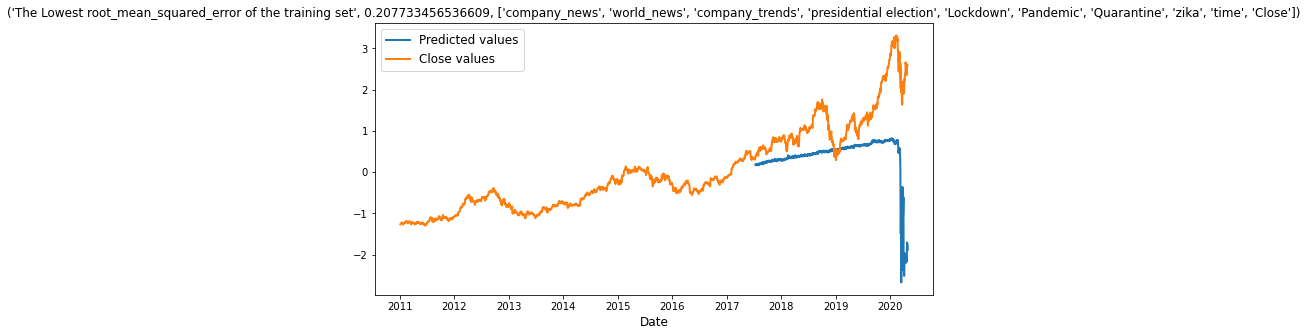

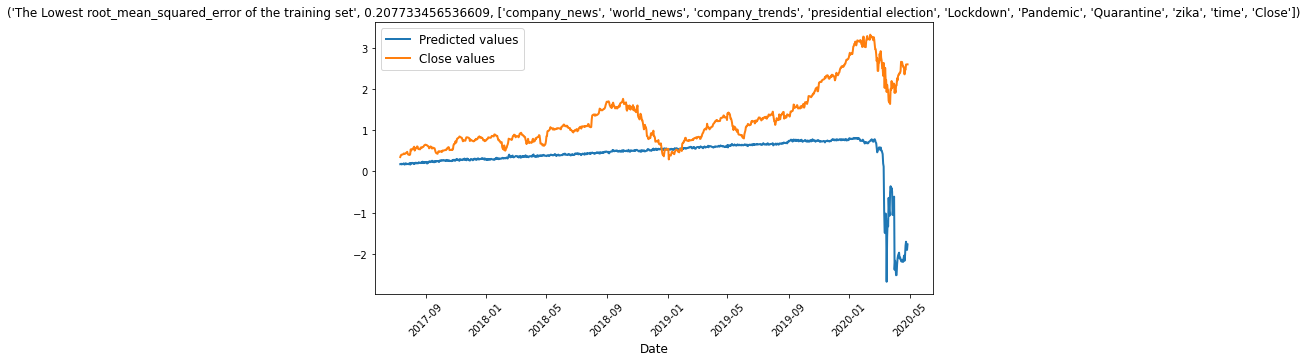

Root_mean_squared_error of the testing set:  1.2536014866738416
neg_mean_squared_error of the testing set:  -2.0283171163972766
mean_absolute_percentage_error of the testing set:  60.197021006018836
R2 score of the testing set:  -2.076373977801339


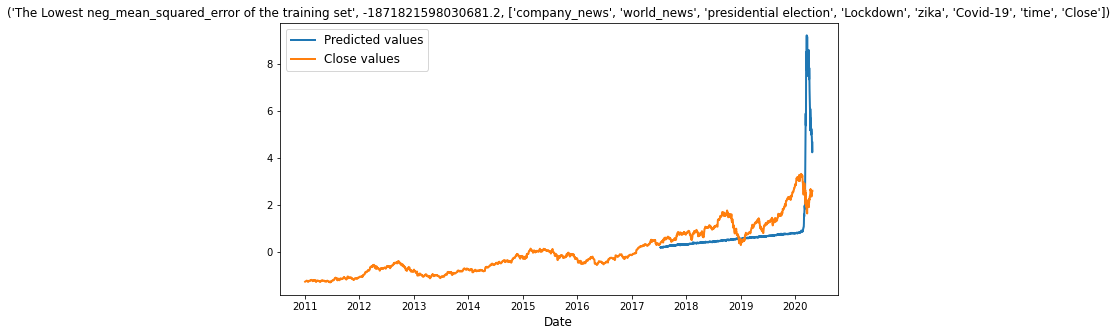

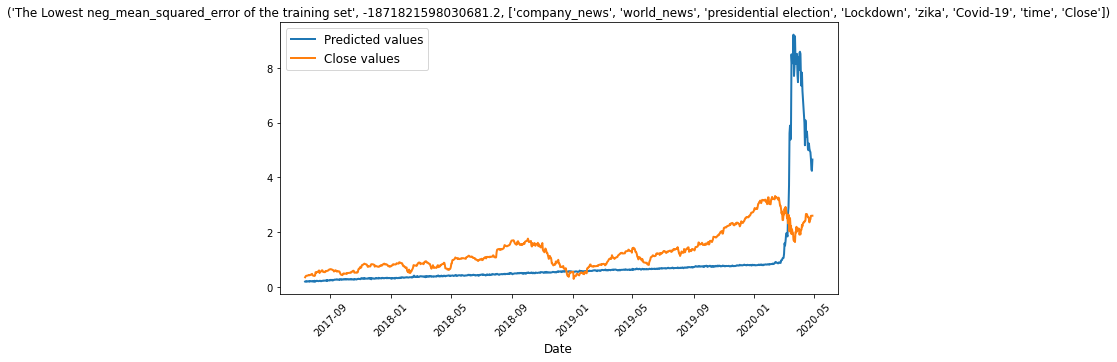

Root_mean_squared_error of the testing set:  1.3564506700265033
neg_mean_squared_error of the testing set:  -3.3368986035226656e+17
mean_absolute_percentage_error of the testing set:  59.82913486190991
R2 score of the testing set:  -2.601870886643098


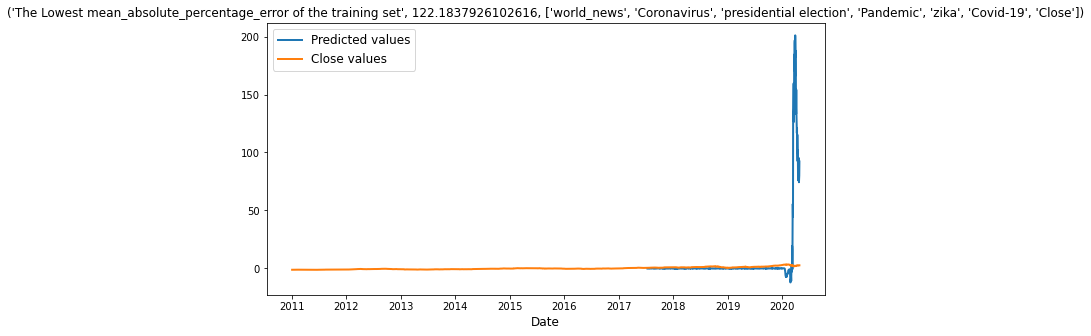

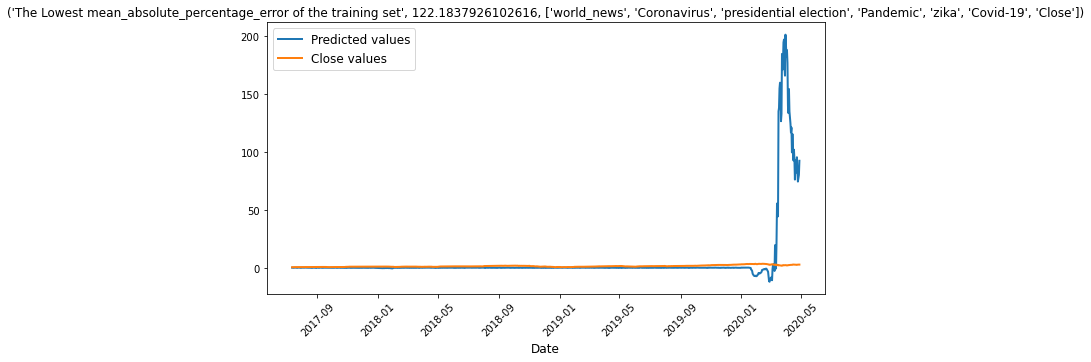

Root_mean_squared_error of the testing set:  28.223546981334074
neg_mean_squared_error of the testing set:  -1869606314131539.2
mean_absolute_percentage_error of the testing set:  382.1524031471825
R2 score of the testing set:  -1558.3489685345037


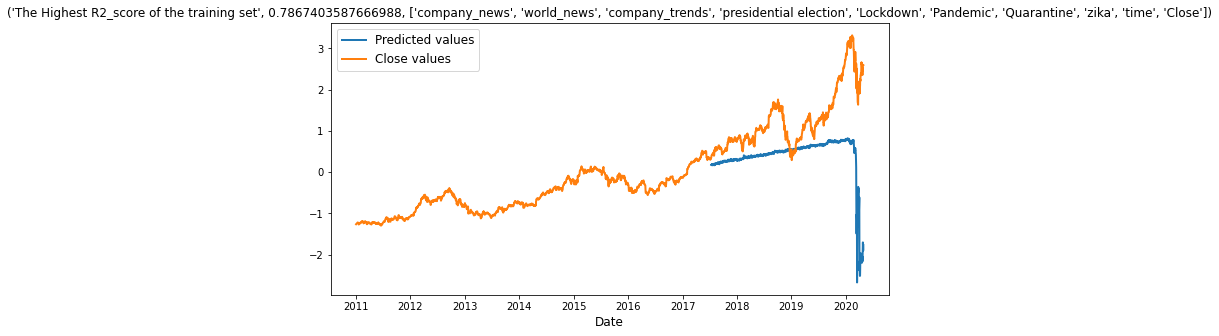

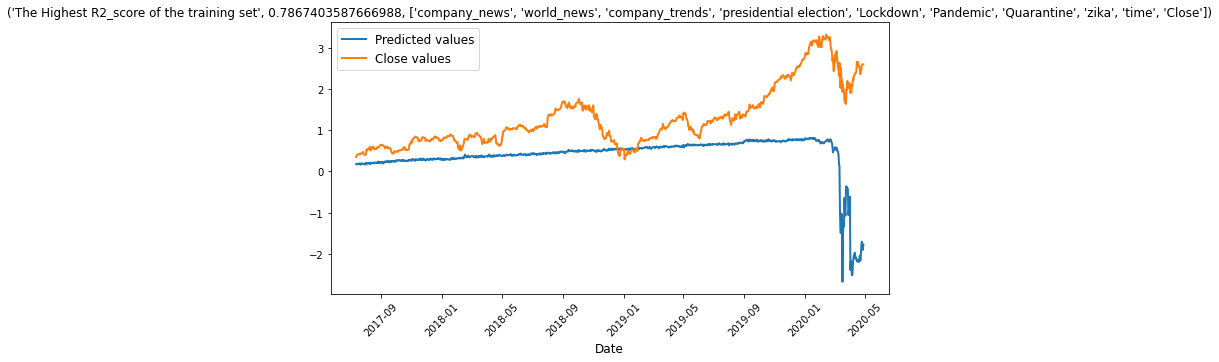

Root_mean_squared_error of the testing set:  1.2536014866738416
neg_mean_squared_error of the testing set:  -2.0283171163972766
mean_absolute_percentage_error of the testing set:  60.197021006018836
R2 score of the testing set:  -2.076373977801339


In [62]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)